In [89]:
!pip install pmdarima

## Occupancy analysis with `pmdarima`



In [90]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.8.0


### Import the data



In [91]:
!git clone https://github.com/valwork2021/Hackathon.git

fatal: destination path 'Hackathon' already exists and is not an empty directory.


In [92]:
fileName = "cba_svlive_activity_by_hour_by_space_type_2021-03-10T2016.csv"
df = pd.read_csv('/content/Hackathon/data/' + fileName)
df

,Space Type Space Type Name,Cockpit,Desk: Hotdesk,Desk: Project Table,Desk: Standard
0,Svlive Activity By Hour Start of Hour Time,Svlive Activity By Hour Active Minutes,Svlive Activity By Hour Active Minutes,Svlive Activity By Hour Active Minutes,Svlive Activity By Hour Active Minutes
1,2021-01-08 21:00:00,NaN,NaN,NaN,387
2,2021-01-08 20:00:00,NaN,NaN,NaN,1851
3,2021-01-08 19:00:00,NaN,NaN,NaN,3952
4,2021-01-08 18:00:00,NaN,NaN,14,9217
...,...,...,...,...,...
686,2020-12-11 03:00:00,NaN,NaN,NaN,870
687,2020-12-11 02:00:00,NaN,NaN,NaN,945
688,2020-12-11 01:00:00,NaN,NaN,NaN,868
689,2020-12-11 00:00:00,NaN,NaN,NaN,439


In [93]:
df.drop(df.index[[0]], inplace=True)
df.fillna(0, inplace=True)
df.iloc[:, 1] = df.iloc[:, 1].astype(float)
df.iloc[:, 2] = df.iloc[:, 2].astype(float)

df

,Space Type Space Type Name,Cockpit,Desk: Hotdesk,Desk: Project Table,Desk: Standard
1,2021-01-08 21:00:00,0.0,0.0,0,387
2,2021-01-08 20:00:00,0.0,0.0,0,1851
3,2021-01-08 19:00:00,0.0,0.0,0,3952
4,2021-01-08 18:00:00,0.0,0.0,14,9217
5,2021-01-08 17:00:00,0.0,0.0,89,18110
...,...,...,...,...,...
686,2020-12-11 03:00:00,0.0,0.0,0,870
687,2020-12-11 02:00:00,0.0,0.0,0,945
688,2020-12-11 01:00:00,0.0,0.0,0,868
689,2020-12-11 00:00:00,0.0,0.0,0,439


### Split the data

We'll use 80% of the samples as training data. Note that a time series' train/test split is different from that of a dataset without temporality; order *must* be preserved if we hope to discover any notable trends.

In [94]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data.iloc[:, 1]
y_test = test_data.iloc[:, 1].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

552 train samples
138 test samples


### Pre-modeling analysis



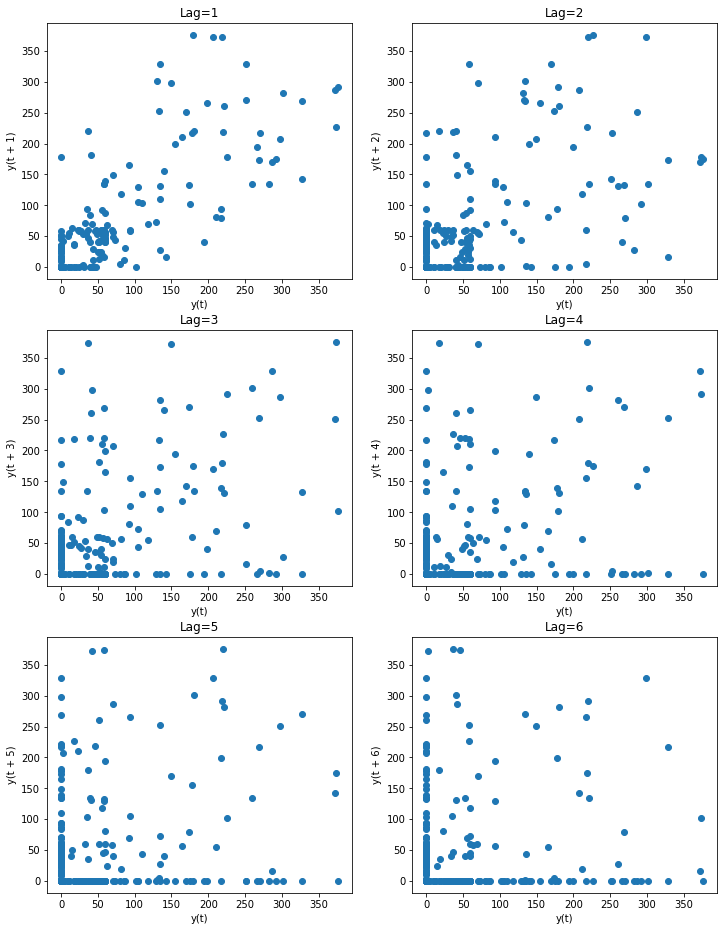

In [95]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df.iloc[:, 1], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

### Estimating the differencing term

We can estimate the best lag term with several statistical tests:

In [96]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


Use `auto_arima` to fit a model on the data.

In [97]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4950.219, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5014.880, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4996.379, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4983.288, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5012.957, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4922.310, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4976.613, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4983.069, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4941.790, Time=0.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4940.701, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4950.170, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4910.583, Time=0.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4909.047, Time=1.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4940.493, Time=1.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

In [98]:
print(auto.order)

(2, 1, 5)


In [99]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 2829.8071262308968
SMAPE: 152.55761201293717


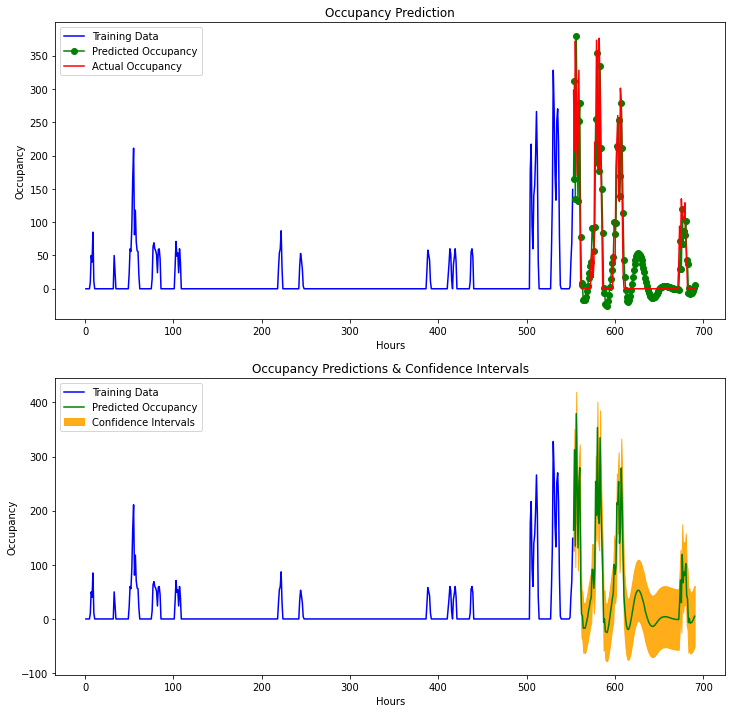

In [100]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Occupancy')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Occupancy')
axes[0].set_title('Occupancy Prediction')
axes[0].set_xlabel('Hours')
axes[0].set_ylabel('Occupancy')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Occupancy')

axes[1].set_title('Occupancy Predictions & Confidence Intervals')
axes[1].set_xlabel('Hours')
axes[1].set_ylabel('Occupancy')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")
axes[1].legend()